# Kriging

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import gstlearn as gl
import gstlearn.plot as gp
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib.request

Then we download the data base **dat**.

In [3]:
url = 'https://soft.minesparis.psl.eu/gstlearn/data/Scotland/Scotland_Temperatures.NF'
temp_nf, head = urllib.request.urlretrieve(url)
dat = gl.Db.createFromNF(temp_nf)

Calculate the experimental variogram **vario2dir** (in 2 directions)

In [4]:
varioParamMulti = gl.VarioParam.createMultiple(2, 15, 15.)
vario2dir = gl.Vario(varioParamMulti, dat)
err = vario2dir.compute()

Calculate the fitted model **fitmodOK** (add the Universality Condition)

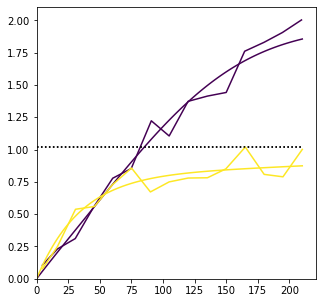

In [5]:
fitmodOK = gl.Model()
err = fitmodOK.fit(vario2dir,types=[gl.ECov.NUGGET, gl.ECov.EXPONENTIAL, gl.ECov.GAUSSIAN])
err = fitmodOK.addDrift(gl.Drift1())
ax = gp.varmod(vario2dir, fitmodOK)

Define the Unique Neighborhood **unique.neigh**.

In [6]:
uniqueNeigh = gl.NeighUnique.create()

Get the extension of the Data:

In [7]:
dat.getExtremas()

array([[  78.2,  460.7],
       [ 530.4, 1208.9]])

Create the Target file **grid**.

In [8]:
grid = gl.DbGrid.create(x0=[65,535],dx=[4.94, 4.96],nx=[81,137])
dbfmt = gl.DbStringFormat.createFromFlags(flag_resume=False, flag_vars=True,
                                          flag_extend=True, flag_stats=False,
                                          flag_array=False)
grid.display(dbfmt)


Data Base Grid Characteristics

Data Base Extension
-------------------
Coor #1 - Min =     65.000 - Max =    460.200 - Ext = 395.2
Coor #2 - Min =    535.000 - Max =   1209.560 - Ext = 674.56

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = x2 - Locator = x2
 

Perform Ordinary Kriging

In [9]:
err = gl.kriging(dat,grid,fitmodOK,uniqueNeigh,namconv=gl.NamingConvention("OK"))

Plotting the results

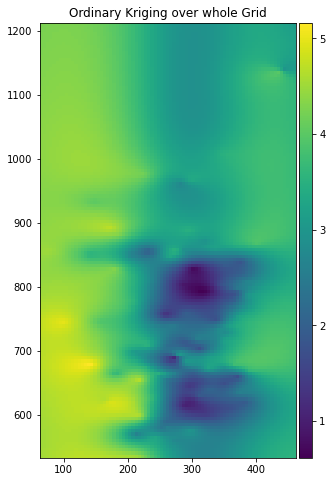

In [10]:
gp.setDefaultGeographic(dims=[8,8])

fig, ax = gp.initGeographic()
ax.raster(grid, flagLegend=True)
ax.decoration(title="Ordinary Kriging over whole Grid")
plt.show()

Reading the Elevation Grid

In [11]:
url = 'https://soft.minesparis.psl.eu/gstlearn/data/Scotland/Scotland_Elevations.NF'
elev_nf, head = urllib.request.urlretrieve(url)
grid = gl.DbGrid.createFromNF(elev_nf)
grid


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 4
Maximum Number of UIDs       = 4
Total number of samples      = 11097
Number of active samples     = 3092

Grid characteristics:
---------------------
Origin :     65.000   535.000
Mesh   :      4.938     4.963
Number :         81       137

Variables
---------
Column = 0 - Name = Longitude - Locator = x1
Column = 1 - Name = Latitude - Locator = x2
Column = 2 - Name = Elevation - Locator = f1
Column = 3 - Name = inshore - Locator = sel

The output grid now contains the selection **inshore**. 
Estimation is restricted to the active cells only.

In [12]:
err = gl.kriging(dat,grid,fitmodOK,uniqueNeigh,namconv=gl.NamingConvention("OK"))

Plotting the Estimation

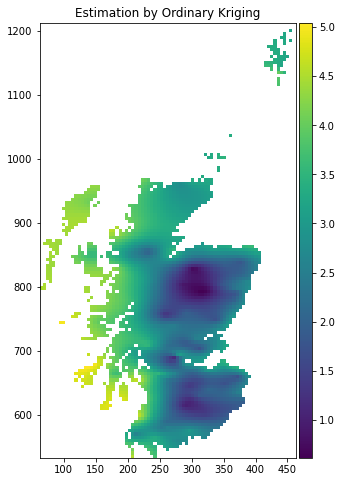

In [13]:
fig, ax = gp.initGeographic()
ax.raster(grid, name="OK*estim", flagLegend=True)
ax.decoration(title="Estimation by Ordinary Kriging")
plt.show()

Plotting the Standard deviation of Estimation Error

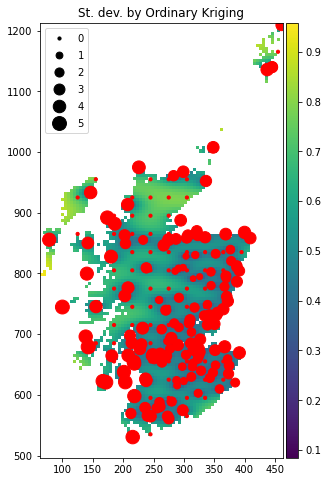

In [14]:
fig, ax = gp.initGeographic()
ax.raster(grid, name="OK*stdev", flagLegend=True)
ax.symbol(dat,name_size="January_temp", flagLegend=True)
ax.decoration(title="St. dev. by Ordinary Kriging")
plt.show()

The Model **fitmodOK** is first duplicated into **fitmodSK**. Then the Universality Condition is deleted.

In [15]:
fitmodSK = fitmodOK.clone()
err = fitmodSK.delDrift(0)
err = fitmodSK.setMean(20.)

Simple Kriging is performed

In [16]:
err = gl.kriging(dat,grid,fitmodSK,uniqueNeigh, namconv=gl.NamingConvention("SK"))

Plotting the Estimation

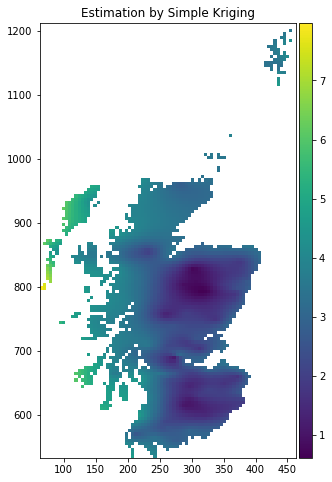

In [17]:
fig, ax = gp.initGeographic()
ax.raster(grid, name="SK*estim", flagLegend=True)
ax.decoration(title="Estimation by Simple Kriging")
plt.show()

Plotting the Standard deviation of the Estimation error

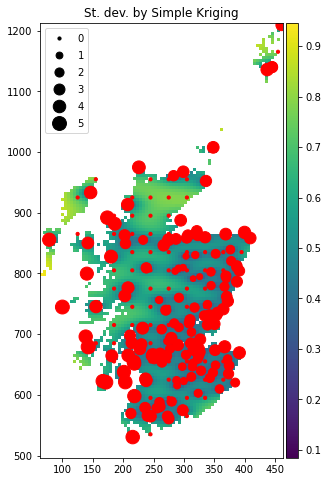

In [18]:
fig, ax = gp.initGeographic()
ax.raster(grid, name="SK*stdev", flagLegend=True)
ax.symbol(dat,name_size="January_temp", flagLegend=True)
ax.decoration(title="St. dev. by Simple Kriging")
plt.show()

Comparing Ordinary and Simple Kriging - Estimations

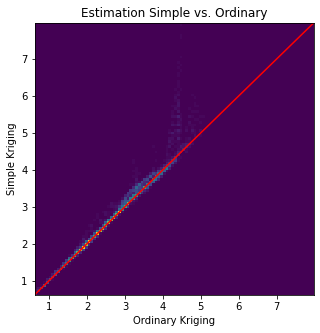

In [19]:
ax = gp.correlation(grid,namex="OK*estim",namey="SK*estim", bissLine=True, bins=100, flagSameAxes=True)
ax.decoration(title="Estimation Simple vs. Ordinary", 
              xlabel="Ordinary Kriging", ylabel="Simple Kriging")

Comparing Ordinary and Simple Kriging - St. dev.

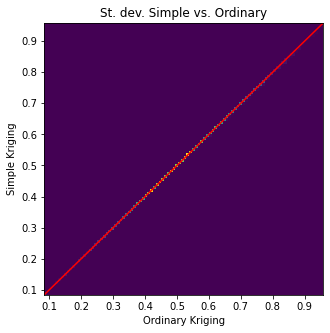

In [20]:
ax = gp.correlation(grid,namex = "OK*stdev",namey="SK*stdev", bissLine=True, bins=100,flagSameAxes=True)
ax.decoration(title="St. dev. Simple vs. Ordinary", 
              xlabel="Ordinary Kriging", ylabel="Simple Kriging")

Cross-Validation

In [21]:
err = gl.xvalid(dat,fitmodOK,uniqueNeigh, 
                namconv=gl.NamingConvention("Xvalid", True, True, False, gl.ELoc.UNKNOWN))

Cross-validation - Histogram of Errors

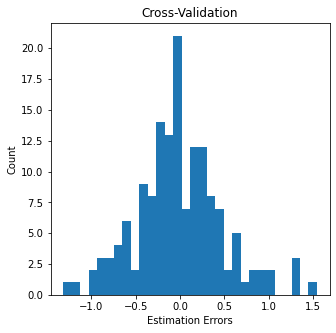

In [22]:
ax = gp.histogram(dat,name="*esterr*",bins=30,fill="blue")
ax.decoration(xlabel="Estimation Errors",title="Cross-Validation")

Cross-validation - Histogram of Standardized Errors

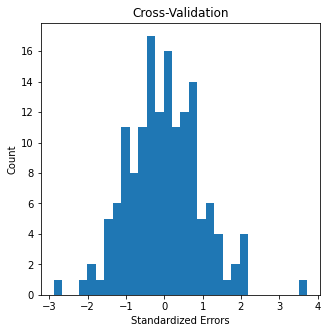

In [23]:
ax = gp.histogram(dat,name="*stderr*",bins=30,fill="blue")
ax.decoration(xlabel="Standardized Errors", title="Cross-Validation")

Cross-validation Scores

In [66]:
print(round(np.nanmean(dat.getColumn("*esterr*")),4))
print(round(np.nanmean(np.square(dat.getColumn("*esterr*"))),4))
print(round(np.nanmean(np.square(dat.getColumn("*stderr*"))),4))

-0.0042
0.2394
0.9118


Display Errors of the Cross Validation

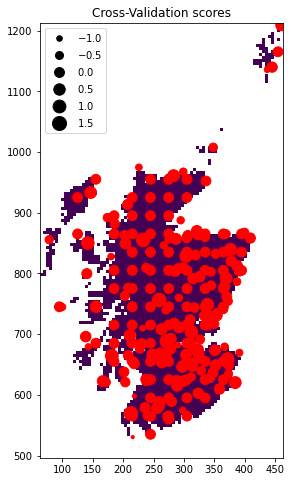

In [46]:
fig, ax = gp.initGeographic()
ax.raster(grid, name="inshore")
ax.symbol(dat,name_size="*esterr", flagLegend=True)
ax.decoration(title="Cross-Validation scores")
plt.show()

Display Errors of the Cross Validation (in absolute value)

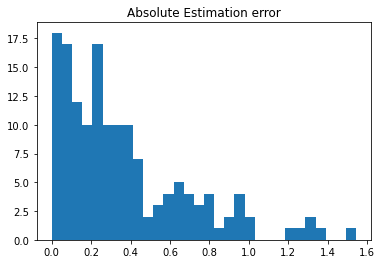

In [65]:
plt.hist(np.absolute(dat["*esterr"]),bins=30)
plt.title("Absolute Estimation error")
plt.show()

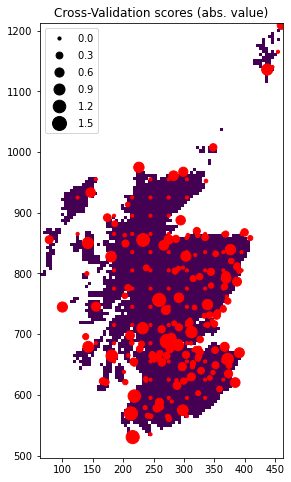

In [52]:
fig, ax = gp.initGeographic()
ax.raster(grid, name="inshore")
ax.symbol(dat,name_size="*esterr", flagAbsSize=True, flagLegend=True)
ax.decoration(title="Cross-Validation scores (abs. value)")
plt.show()

We design a small Moving Neighborhood **small.neigh** with only 1 sample per neighborhood but with an infinite extension (*radius*).

In [53]:
smallNeigh = gl.NeighMoving.create(flag_xvalid=False, nmini=1, nmaxi=1, radius=1000000)

We perform Ordinary Kriging

In [54]:
err = gl.kriging(dat,grid,fitmodOK,smallNeigh,namconv=gl.NamingConvention("Small"))

Graphic representation

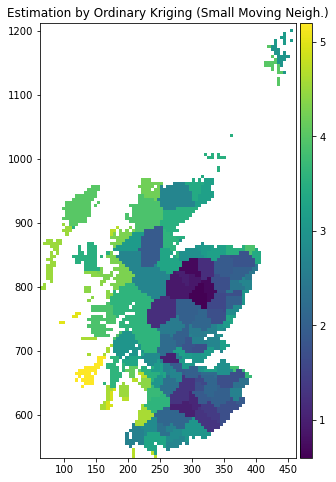

In [55]:
fig, ax = gp.initGeographic()
ax.raster(grid, name="Small*estim", flagLegend=True)
ax.decoration(title="Estimation by Ordinary Kriging (Small Moving Neigh.)")
plt.show()

Building a reasonable Moving Neighborhood, although with a limited extension (*radius*)

In [56]:
movingNeigh = gl.NeighMoving.create(nmini=1, nmaxi=10, radius=20)

Running the Ordinary Kriging

In [57]:
err = gl.kriging(dat,grid,fitmodOK,movingNeigh, namconv=gl.NamingConvention("Reduced"))

Plotting the results

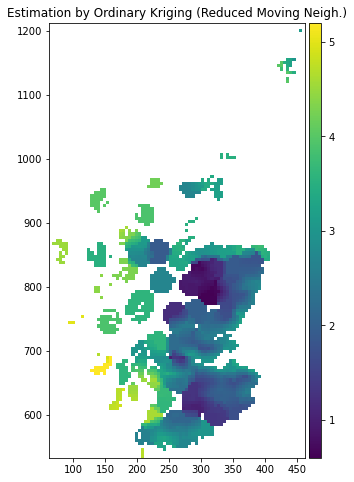

In [58]:
fig, ax = gp.initGeographic()
ax.raster(grid, name="Reduced*estim", flagLegend=True)
ax.decoration(title="Estimation by Ordinary Kriging (Reduced Moving Neigh.)")
plt.show()

Lots of target sites are not estimated as no sample is found within the neighborhood.

Building a reasonable Moving Neighborhood correctly tuned: 10 samples (maximum) selected in a radius of 150 around the target site.

In [59]:
movingNeigh = gl.NeighMoving.create(nmini=1, nmaxi=10, radius=150)

Running the Ordinary Kriging

In [60]:
err = gl.kriging(dat,grid,fitmodOK,movingNeigh, namconv=gl.NamingConvention("Moving"))

Graphic representation

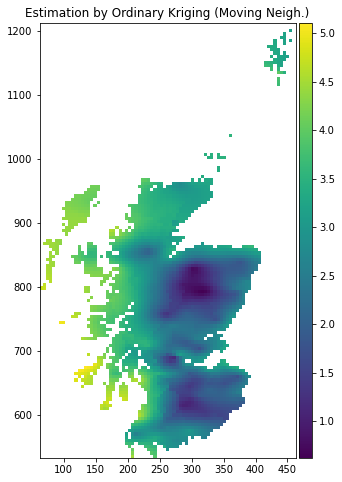

In [61]:
fig, ax = gp.initGeographic()
ax.raster(grid, name="Moving*estim", flagLegend=True)
ax.decoration(title="Estimation by Ordinary Kriging (Moving Neigh.)")
plt.show()

For the standard deviation of Estimation error

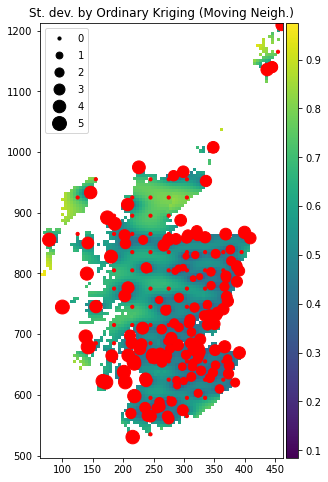

In [62]:
fig, ax = gp.initGeographic()
ax.raster(grid, name="Moving*stdev", flagLegend=True)
ax.symbol(dat,name_size="January_temp", flagLegend=True)
ax.decoration(title="St. dev. by Ordinary Kriging (Moving Neigh.)")
plt.show()

Comparing Unique and Moving Neighborhoods: Estimations

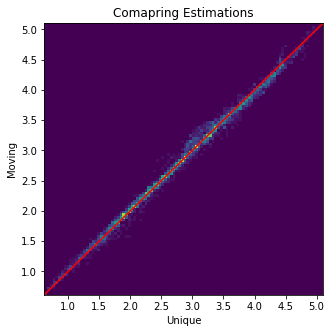

In [63]:
ax = gp.correlation(grid,namex = "OK*estim",namey="Moving*estim", bins=100, bissLine=True, flagSameAxes=True)
ax.decoration(title="Comparing Estimations", xlabel="Unique", ylabel="Moving")

Comparing Unique and Moving Neighborhoods: Standard deviations

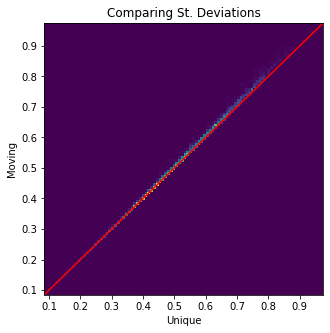

In [64]:
ax = gp.correlation(grid,namex = "OK*stdev",namey="Moving*stdev", bins=100, bissLine=True, flagSameAxes=True)
ax.decoration(title="Comparing St. Deviations", xlabel="Unique", ylabel="Moving")